# CS5785 - Applied Machine Learning (Fall 2023)
## Project: Machine Learning For Audio Signal Classification
Team Members:  William Reid Hernandez (wjr83), Kexin Cheng (kc2248), Hongjin Quan (hq48)

In [ ]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Change to directory where audio data is located (run only once)

# William's File Path
try:
  %pwd
  %ls
  %cd "drive/MyDrive/ColabNotebooks/CS5785_AppliedMachineLearning/Project"
  %ls
except:
# Kexin's File Path
  %pwd
  %ls
  %cd "/content/drive/MyDrive/Project"
  %ls

drive/  sample_data/
[Errno 2] No such file or directory: 'drive/MyDrive/ColabNotebooks/CS5785_AppliedMachineLearning/Project'
/content
drive/  sample_data/


In [ ]:
%ls

drive/  sample_data/


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import librosa

# Step 1: Data Preprocessing

# Specify your data directory where each folder contains audio samples for a specific instrument category.
data_dir = "instrument_classification"



In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

data_dir = "instrument_classification"
csv_file = "TinySOL_metadata.csv"

# Load the CSV file containing labels
df = pd.read_csv(csv_file)

df.head()

,Path,Fold,Family,Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID,Dynamics,Dynamics ID,Instance ID,String ID (if applicable),Needed digital retuning
0,Brass/Bass_Tuba/BTb-ord-F#1-pp-N-N.wav,2,Brass,BTb,Bass Tuba,ord,ordinario,F#1,30,pp,0,0,NaN,False
1,Brass/Bass_Tuba/BTb-ord-G1-pp-N-R100u.wav,4,Brass,BTb,Bass Tuba,ord,ordinario,G1,31,pp,0,0,NaN,True
2,Brass/Bass_Tuba/BTb-ord-G#1-pp-N-T16u.wav,3,Brass,BTb,Bass Tuba,ord,ordinario,G#1,32,pp,0,0,NaN,True
3,Brass/Bass_Tuba/BTb-ord-A1-pp-N-T23d.wav,2,Brass,BTb,Bass Tuba,ord,ordinario,A1,33,pp,0,0,NaN,True
4,Brass/Bass_Tuba/BTb-ord-A#1-pp-N-N.wav,0,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34,pp,0,0,NaN,False


If the audio files vary in length from 2 seconds to 10 seconds, it's important to handle this variability during data preprocessing. This can be achieved by either:

  1. Segmentation: Split the longer audio clips into smaller, fixed-size segments (e.g., 2-second segments) and treat each segment as a separate example.

  2. Padding: Pad the shorter audio clips to make them equal in length to the longest clip (2 seconds after segmentation has occured). While this ensures uniform input dimensions, it may introduce some silence in the shorter clips.

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Import padding function
import math

# Assuming 'df' is your Pandas DataFrame
file_paths = df.iloc[:, 0].tolist()  # Get the file paths from the first column
labels = df.iloc[:, 4].tolist()  # Get the labels from the fifth column (instruments). To get the labels from the Family, use column 3 ()

# Initialize empty lists for features and labels
features = []
label_names = []  # To store the label names (instrument names)

data_dir = "/content/drive/MyDrive/instrument_classification"  # Path to the directory containing the audio files
segment_duration = 2  # Duration of each segment in seconds

for file_path, label in zip(file_paths, labels):
    audio_path = os.path.join(data_dir, file_path)  # Create the full audio file path
    # Load the audio
    audio_data, sr = librosa.load(audio_path, sr=None)
    # Split the audio into segments of fixed duration
    for i in range(0, len(audio_data), int(segment_duration * sr)):
        segment = audio_data[i:i + int(segment_duration * sr)]
        n_fft = min(2048, len(segment) // 2)  # Set n_fft to the smaller of 2048 or half the segment length. Experiment with tuning this hyperparameter
        # Extract audio features using Librosa
        mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_fft=n_fft)
        features.append(mfccs.T)  # Transpose MFCCs to shape (time_steps, num_features)
        label_names.append(label)

/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


file_paths and labels are extracted from the Pandas DataFrame. file_paths contains the paths to the audio files, and labels contains the corresponding class labels (instruments in this case).

The code initializes empty lists for features and label_names. These lists will store the audio features and the label names, respectively.

The variable data_dir is set to the directory containing the audio files.

segment_duration is set to 2 seconds. This is the duration of each audio segment into which the audio files will be divided.

The code loops through each file path and label:
It constructs the full audio file path by joining data_dir and the file path.
It loads the audio data from the file using the librosa library.
The audio data is then divided into segments of the specified duration, in this case, 2 seconds. Each segment represents a smaller piece of the audio file.
The variable n_fft is calculated to determine the number of samples in each short-time window of the Short-Time Fourier Transform (STFT). The min function sets n_fft to the smaller of 2048 or half the segment length. This is an important hyperparameter to control the trade-off between time and frequency resolution in audio feature extraction.
Librosa is used to extract Mel-frequency cepstral coefficients (MFCCs) from each segment. MFCCs are commonly used audio features for speech and audio processing tasks. These features capture the spectral characteristics of audio signals.
The extracted MFCCs are transposed to have a shape of (time_steps, num_features). This shape is suitable for input into machine learning models.

  The label names (instrument names) are appended to the label_names list.

The n_fft (short for "number of samples in each short-time window of the STFT") parameter is used in the context of the Short-Time Fourier Transform (STFT) calculation, which is an essential component of audio feature extraction, including Mel-Frequency Cepstral Coefficients (MFCCs). The STFT divides a longer audio signal into shorter overlapping windows, and n_fft specifies the number of samples in each of these windows.

A warning we encountered previously, "n_fft is too large for input signal of length", suggested that the n_fft value we had chosen was greater than the length of the input audio signal. This is problematic because the STFT window should be shorter than the input signal to allow for overlap.

The n_fft value should be shorter than the average duration of a meaningful sound event in the dataset.

Choose an n_fft that balances time and frequency resolution: There's no one-size-fits-all value for n_fft since it depends on the specific characteristics of your audio data. As a starting point, you can consider values in the range of 512 to 2048. Smaller values like 512 provide good time resolution and are suitable for analyzing short audio segments, while larger values like 2048 offer better frequency resolution and are more appropriate for longer audio segments.

Experiment and test: It's often necessary to experiment with different n_fft values and observe the trade-offs in your results. For instance, try different n_fft values and evaluate the quality of the extracted features (e.g., MFCCs) in terms of their relevance to your audio classification task.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

# Pad the MFCCs to ensure consistent shape
features = pad_sequences(features, dtype='float32', padding='post')

# Flatten the features to ensure a 2D shape
features = features.reshape(features.shape[0], -1)

# Convert features and label names to NumPy arrays
features = np.array(features)
label_names = np.array(label_names)

# Initialize StratifiedShuffleSplit
# This code uses StratifiedShuffleSplit to ensure a balanced class ratio in both the training and validation sets.
n_splits = 1  # Can change the number of splits if needed
stratified_splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)

# Create a generator for the splits
splits = stratified_splitter.split(features, label_names)

# Loop through the splits (in this case, just one split)
for train_index, validation_index in splits:
    X_train, X_val = features[train_index], features[validation_index]
    y_train, y_val = label_names[train_index], label_names[validation_index]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, label_names, test_size=0.2, random_state=42)

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [ ]:
# print(X_train.shape)
# print(X_val.shape)
# print(y_train.shape)
# print(y_val.shape)


(8932, 3460)
(2233, 3460)
(8932,)
(2233,)


In [ ]:
# After encoding labels into integers, it's a good practice to use one-hot encoding for classification tasks.
# from tensorflow.keras.utils import to_categorical
# y_train_categorical = to_categorical(y_train_encoded)
# y_val_categorical = to_categorical(y_val_encoded)

# print("Shape of X_train:", X_train.shape)
# print("Shape of X_val:", X_val.shape)
# print("Shape of y_train_categorical:", y_train_categorical.shape)

# # CNN requires 3-layer dataset, while X_train is 1D array
# # reshape X_train and X_val
# import numpy as np
# size = int(np.ceil(np.sqrt(8932)))
# total_size = size * size
# padding = total_size - 8932

# # Initialize a new array with zeros
# X_train_padded = np.zeros((X_train.shape[0], size, size))

# for i, sample in enumerate(X_train):
#     padded_sample = np.pad(sample, (0, padding), 'constant')
#     X_train_padded[i, :] = padded_sample.reshape((size, size))

# X_train_reshaped = X_train_padded[..., np.newaxis]

# X_val_padded = np.zeros((X_val.shape[0], size, size))

# for i, sample in enumerate(X_val):
#     padded_sample = np.pad(sample, (0, padding), 'constant')
#     X_val_padded[i, :] = padded_sample.reshape((size, size))

# X_val_reshaped = X_val_padded[..., np.newaxis]

# # implement CNN model
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),  # New layer
#     MaxPooling2D((2, 2)),  # New layer
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(y_train_categorical.shape[1], activation='softmax')
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(X_train_reshaped, y_train_categorical, validation_data=(X_val_reshaped, y_val_categorical), epochs=5, batch_size=32)
# val_loss, val_accuracy = model.evaluate(X_val_reshaped, y_val_categorical)
# print(f"Validation accuracy: {val_accuracy}")

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout

# # Example: Reshape X_train from (samples, features) to (samples, timesteps, features_per_timestep)
# X_train=X_train.T

# # Example where each feature is a timestep
# timesteps = X_train.shape[1]  # The entire length of the feature vector
# features_per_timestep = 1     # Since each feature is a timestep
# X_train_reshaped = X_train.reshape(-1, timesteps, features_per_timestep)

# X_val=X_val.T

# # Example where each feature is a timestep
# timesteps = X_val.shape[1]  # The entire length of the feature vector
# features_per_timestep = 1     # Since each feature is a timestep
# X_val_reshaped = X_val.reshape(-1, timesteps, features_per_timestep)


# model = Sequential()
# model.add(LSTM(64, return_sequences=True, input_shape=(timesteps, features_per_timestep)))
# model.add(LSTM(32, return_sequences=False))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.fit(X_train_reshaped, y_train_categorical, validation_data=(X_val_reshaped, y_val_categorical), epochs=5, batch_size=64)

# val_loss, val_accuracy = model.evaluate(X_val_reshaped, y_val_categorical)
# print(f"Validation accuracy: {val_accuracy}")



Shape of X_train: (8932, 3460)
Shape of X_val: (2233, 3460)
Shape of y_train_categorical: (8932, 14)


ValueError: ignored

In [ ]:
import pandas as pd
from collections import Counter

# Count occurrences of each class in the training and validation sets
train_class_counts = Counter(y_train)
val_class_counts = Counter(y_val)

# Calculate the total number of samples in each set
total_train_samples = len(y_train)
total_val_samples = len(y_val)

# Calculate the class ratios
train_class_ratios = {label: count / total_train_samples for label, count in train_class_counts.items()}
val_class_ratios = {label: count / total_val_samples for label, count in val_class_counts.items()}

# Create DataFrames for the class ratios
train_df = pd.DataFrame(list(train_class_ratios.items()), columns=['Class', 'Training Set'])
val_df = pd.DataFrame(list(val_class_ratios.items()), columns=['Class', 'Validation Set'])

# Merge the DataFrames
class_ratios_df = pd.merge(train_df, val_df, on='Class', how='outer').fillna(0)

# Sort the DataFrame by class name
class_ratios_df = class_ratios_df.sort_values(by='Class')

# Display the DataFrame
class_ratios_df

,Class,Training Set,Validation Set
4,Accordion,0.243506,0.254814
9,Alto Saxophone,0.037841,0.037170
13,Bass Tuba,0.015674,0.018361
10,Bassoon,0.034819,0.038065
5,Cello,0.112405,0.112853
3,Clarinet in Bb,0.046350,0.040752
2,Contrabass,0.092924,0.095835
0,Flute,0.043103,0.033587
1,French Horn,0.045567,0.047918
6,Oboe,0.038401,0.036722


In [ ]:
from sklearn.preprocessing import StandardScaler

# # Scale the features to help with convergence for Logistic Regression
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)

# Step 3: Model Selection and Training

# Initialize and train the models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5), # experiment with the number k
    "SVM": SVC(kernel='linear', C=1),
    "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Decision Tree": DecisionTreeClassifier(),
    "GaussianNB": GaussianNB(),
}

for model_name, model in models.items():
  model.fit(X_train, y_train)
  # if model_name == "Logistic Regression":
  #     model.fit(X_train_scaled, y_train)
  # else:
  #   model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: KNN
Confusion Matrix:
[[544   1   0   0   2   0   5   3   1   0   0   0   0  13]
 [  8  60   1   1   1   3   0   0   2   2   0   1   1   3]
 [  4   0  36   0   0   0   0   0   1   0   0   0   0   0]
 [  2   0   1  69   0   0   0   0   6   0   6   0   1   0]
 [ 13   1   0   1 203   0  12   1   0   0   0   0  17   4]
 [  8   2   0   2   3  62   2   2   1   7   0   2   0   0]
 [ 36   0   0   0  25   0 145   0   0   0   0   0   3   5]
 [  1   2   0   0   1   1   0  66   3   0   0   1   0   0]
 [  7   2   3   3   0   1   0   2  87   0   2   0   0   0]
 [  3   2   0   0   2   5   0   6   0  63   0   1   0   0]
 [  1   2   2   2   1   0   0   1   4   0  52   1   0   0]
 [  9   1   1   2   0   3   0   4   1   0   1  56   0   0]
 [ 13   0   0   0   8   0   5   0   0   0   0   0 220  11]
 [ 14   0   0   0   6   0   3   0   0   0   0   0   9 201]]
Accuracy: 0.8347514554411106
Precision: 0.8393473816241885
F1 Score: 0.8171464787170345
                precision    recall  f1-score   support


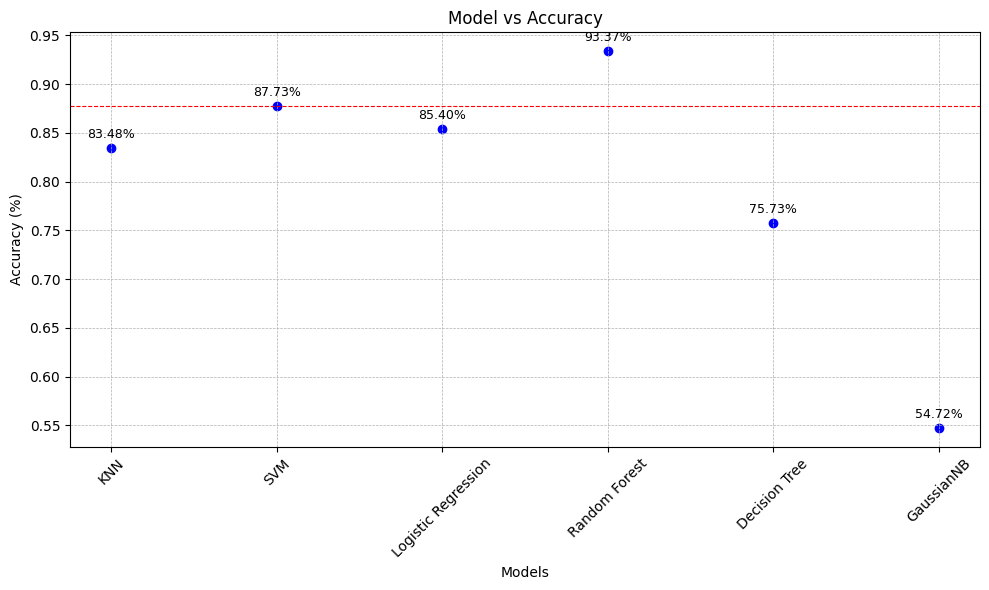

In [ ]:
import matplotlib.pyplot as plt

# Step 4: Model Evaluation and Error Analysis

accuracies = []
precisions = []
f1_scrs = []

for model_name, model in models.items():
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    precision = precision_score(y_val, y_pred, average='macro')
    precisions.append(precision)
    f1 = f1_score(y_val, y_pred, average='macro')
    f1_scrs.append(f1)

    print(f"Model: {model_name}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(classification_report(y_val, y_pred))

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(models.keys(), accuracies, color='blue')
plt.axhline(y=accuracies[1], color='red', linestyle='--', linewidth=0.8)  # accuracies[1] = SVM
for i, txt in enumerate(accuracies):
    plt.annotate(f"{txt*100:.2f}%", (list(models.keys())[i], accuracies[i] + 0.01), ha='center', fontsize=9)
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model vs Accuracy')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
models = ["VGGish", "KNN", "SVM", "Logistic Regression", "Random Forest", "Decision Tree", "GaussianNB"]
accuracy = [80.4460, 83.47, 88.04, 84.82, 94.13, 77.25, 54.72] # Update these values to include the latest values from above, including that of the VGGish model
# plot
plt.figure(figsize=(10, 6))
plt.scatter(models, accuracy, color='blue')
plt.axhline(y=80.4460, color='red', linestyle='--', linewidth=0.8)
for i, txt in enumerate(accuracy):
    plt.annotate(f"{txt:.2f}%", (models[i], accuracy[i] + 1), ha='center', fontsize=9)
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model vs Accuracy')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

models_accuracy = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='linear', C=1),
    "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Decision Tree": DecisionTreeClassifier(),
    "GaussianNB": GaussianNB(),
}

for model_name, model in models.items():
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')
    print(f"Model: {model_name}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(classification_report(y_val, y_pred))

##Improve display output of confusion matrix:

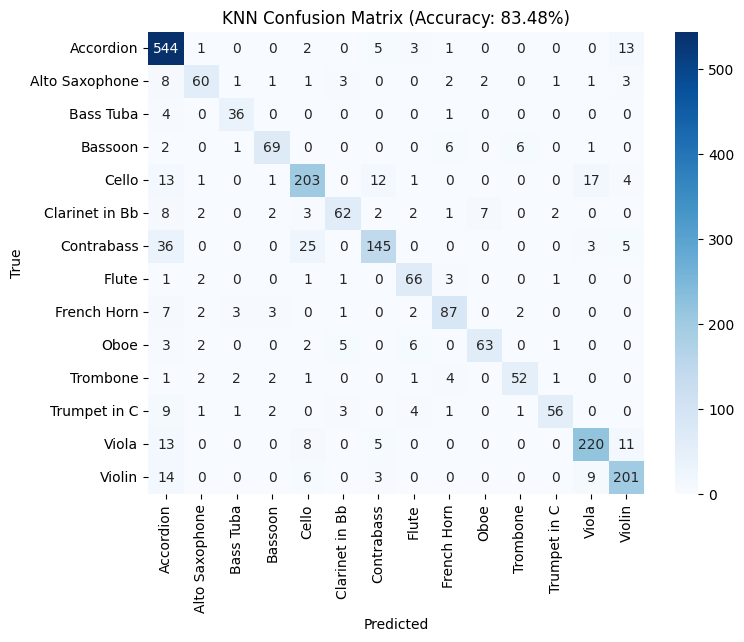

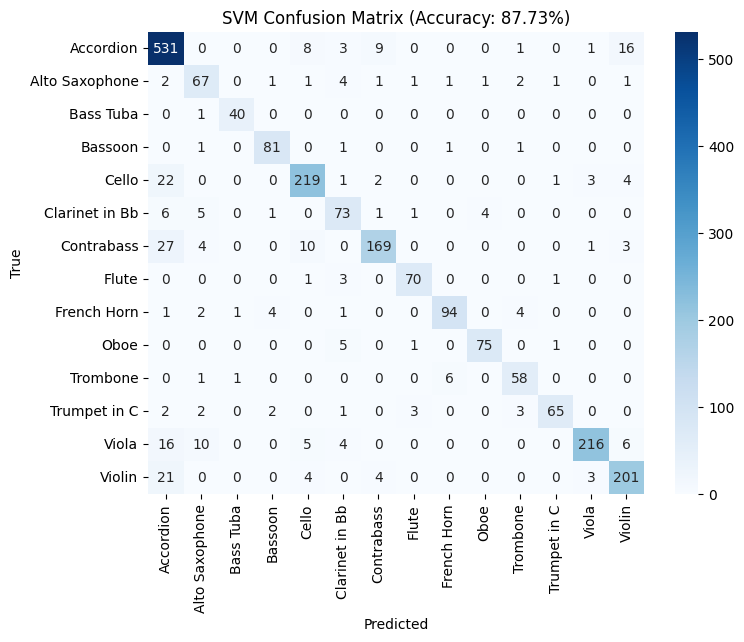

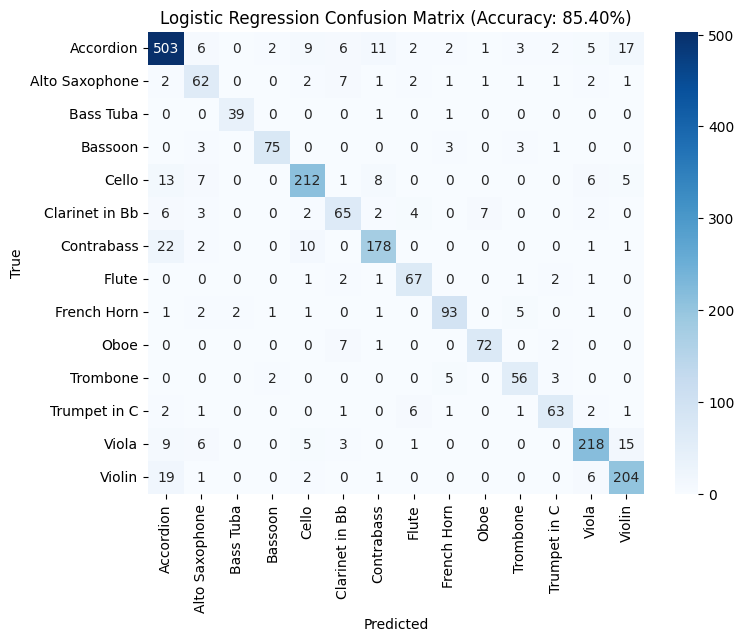

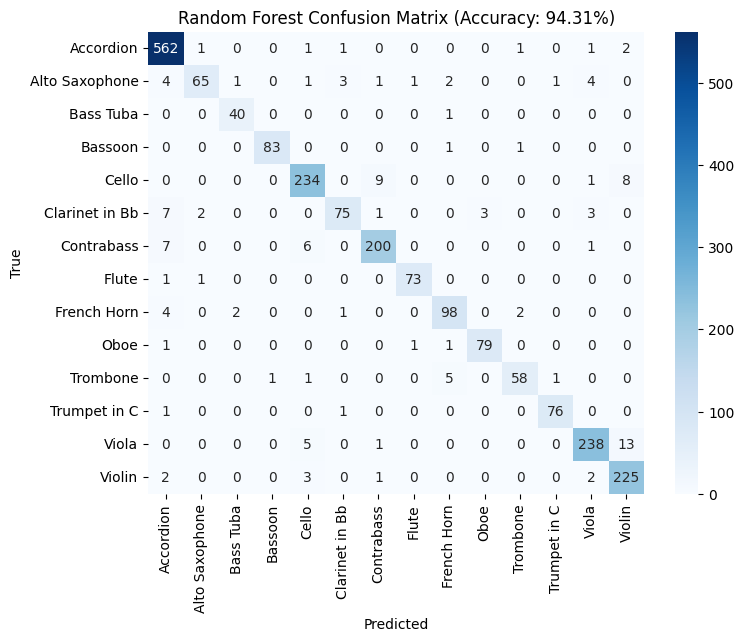

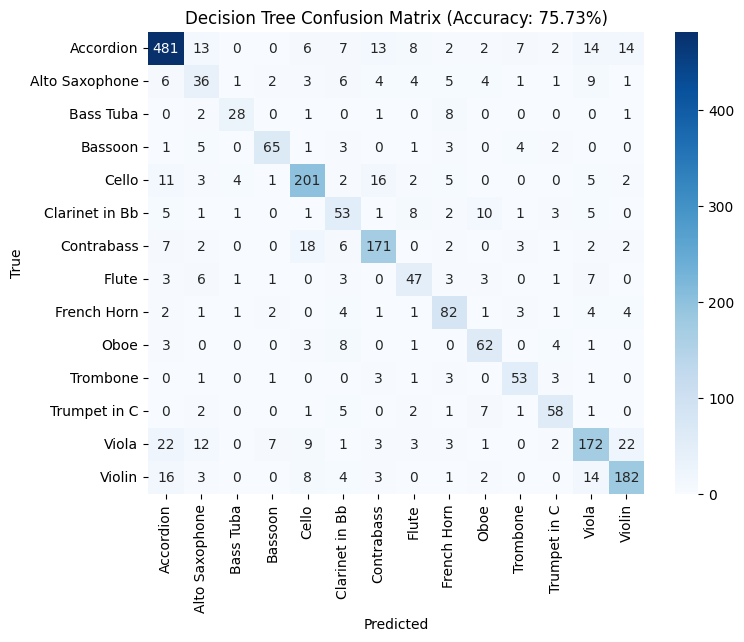

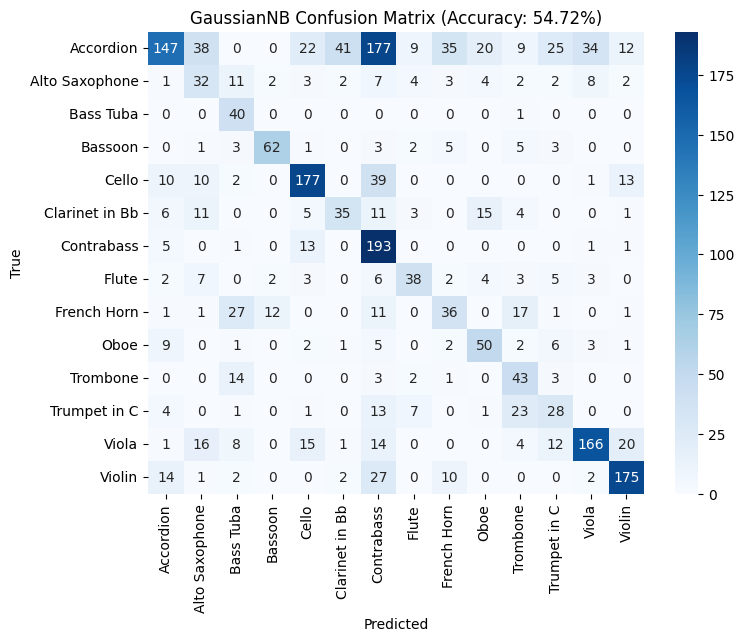

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

for model_name, model in models.items():
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)

     # Get unique label names
    labels = sorted(set(y_val))

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')
# Visualize the confusion matrix with a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix (Accuracy: {accuracy * 100:.2f}%)')
    plt.show()

Adding additional features to the display:

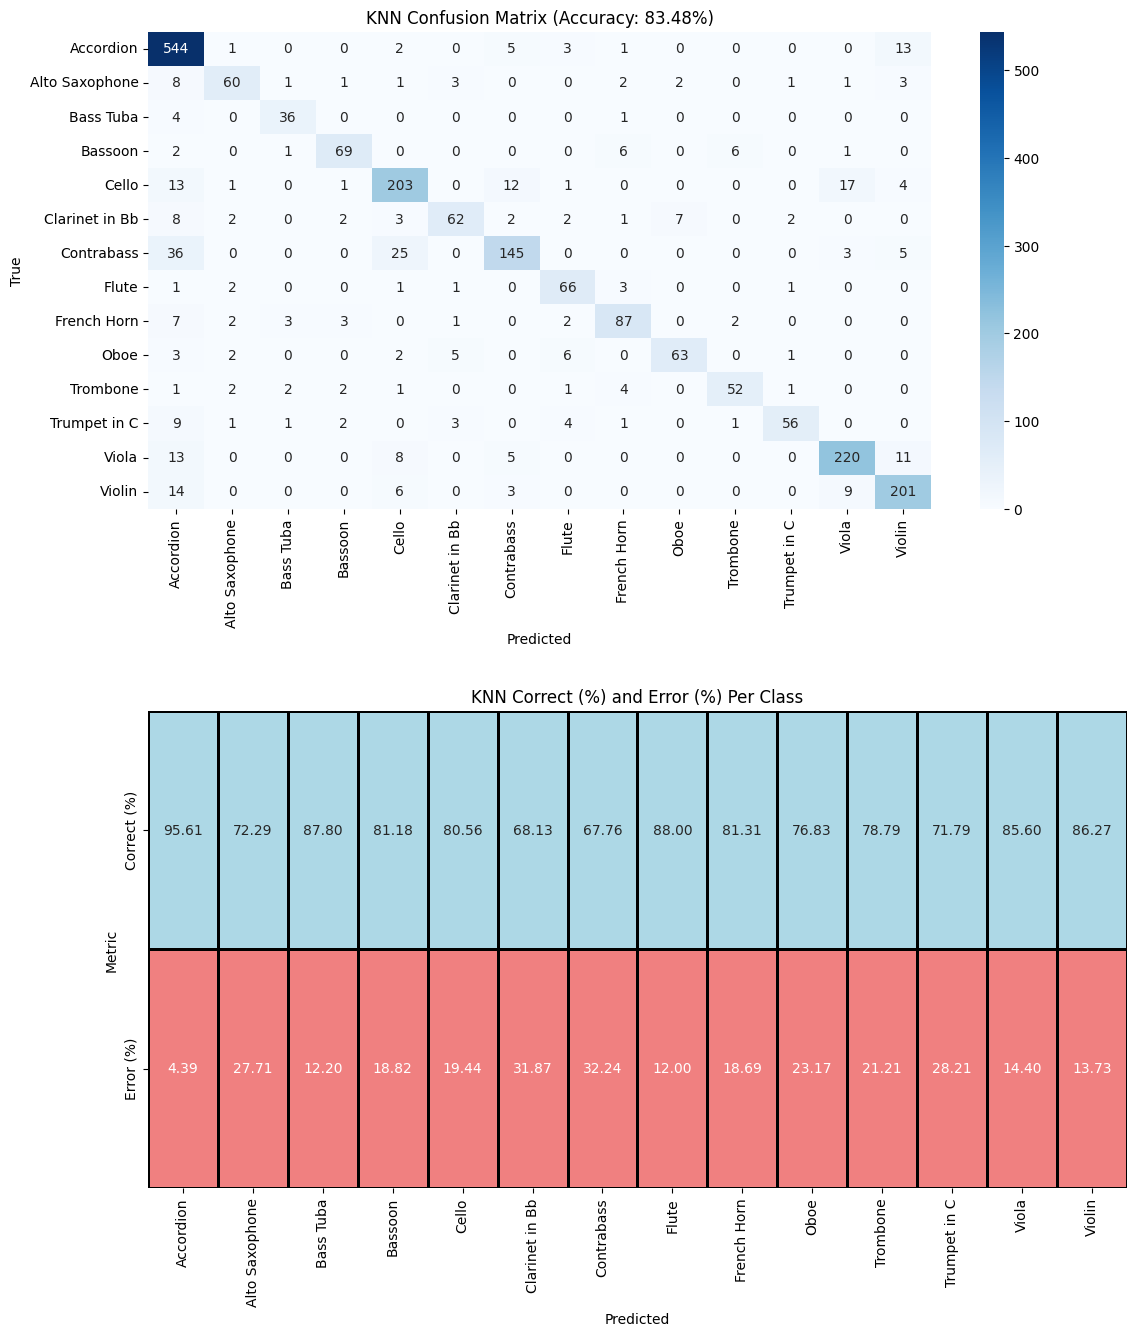

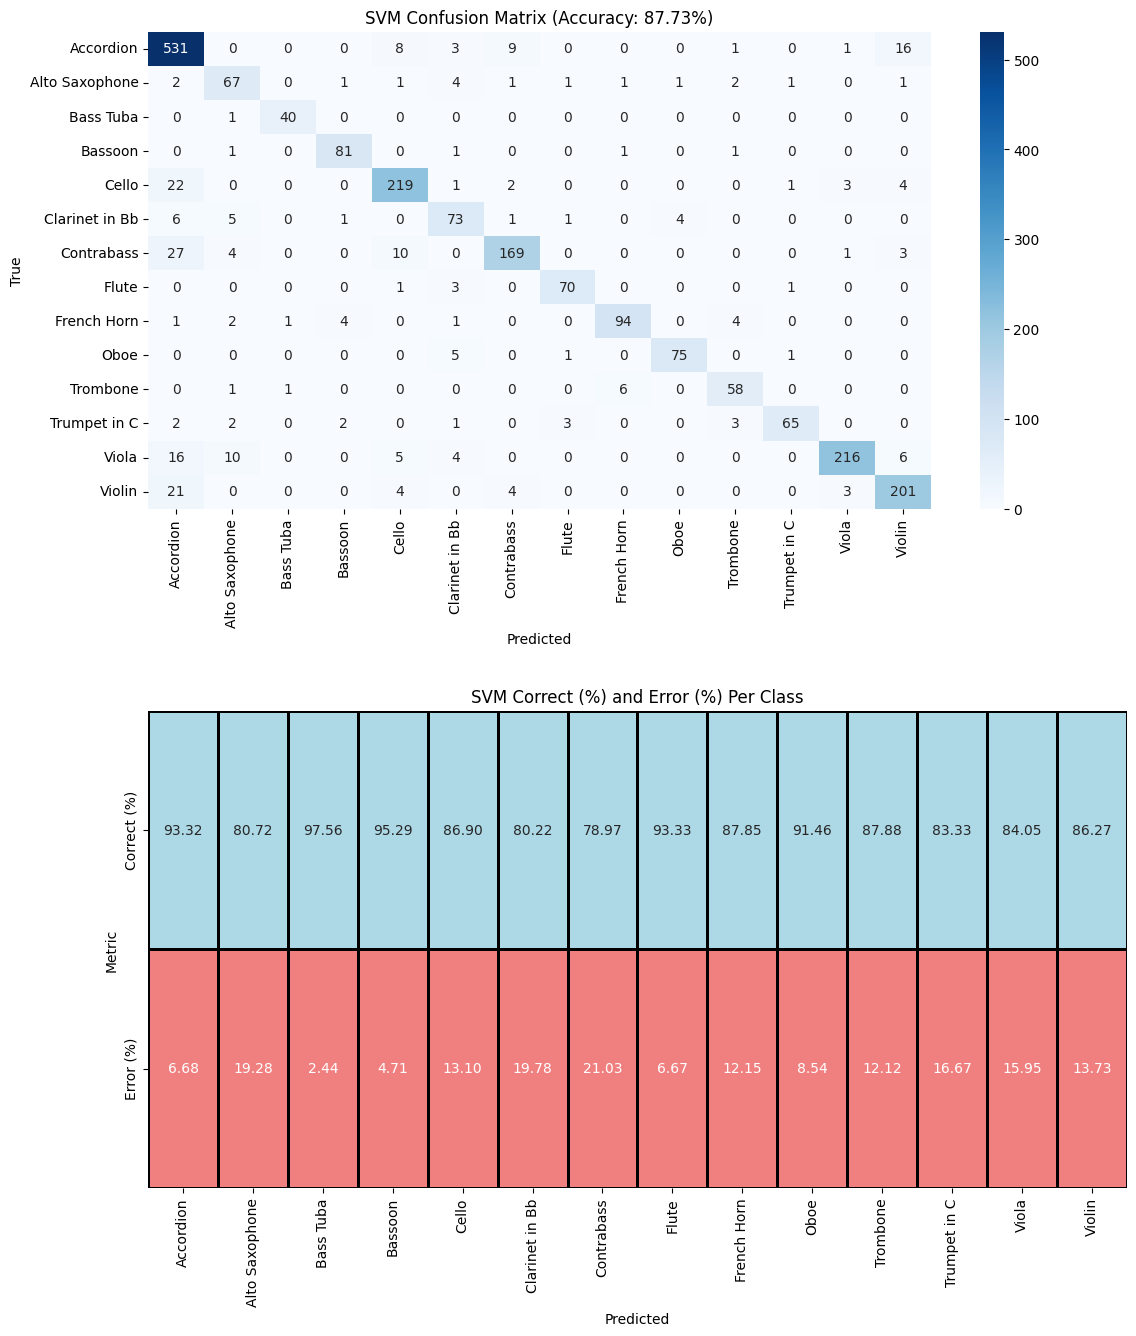

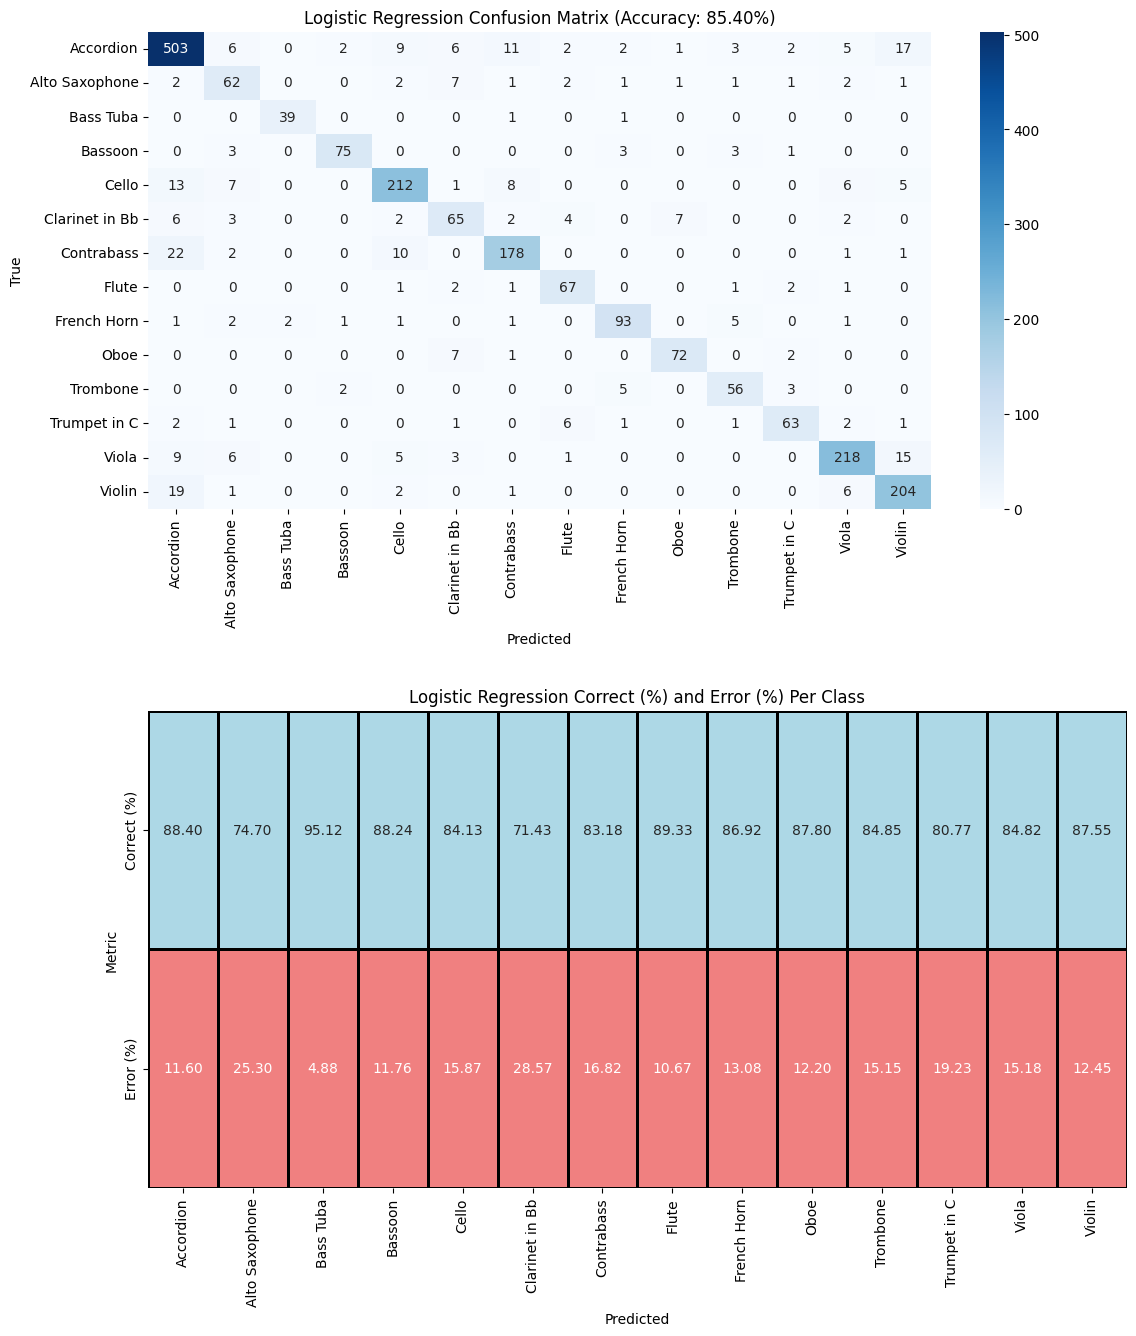

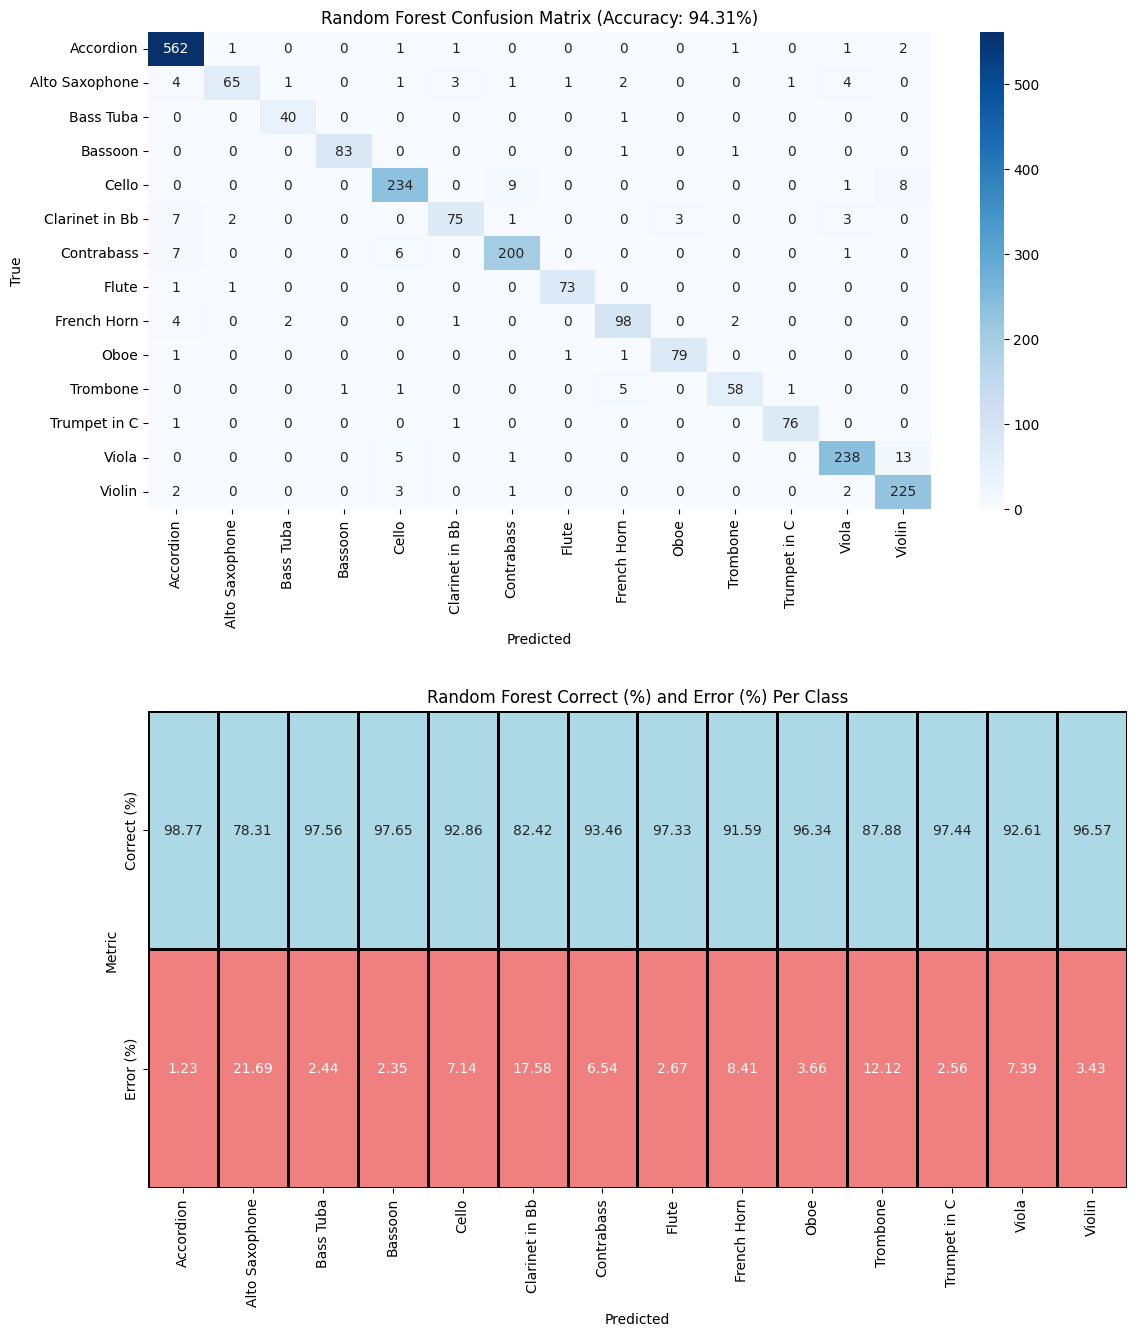

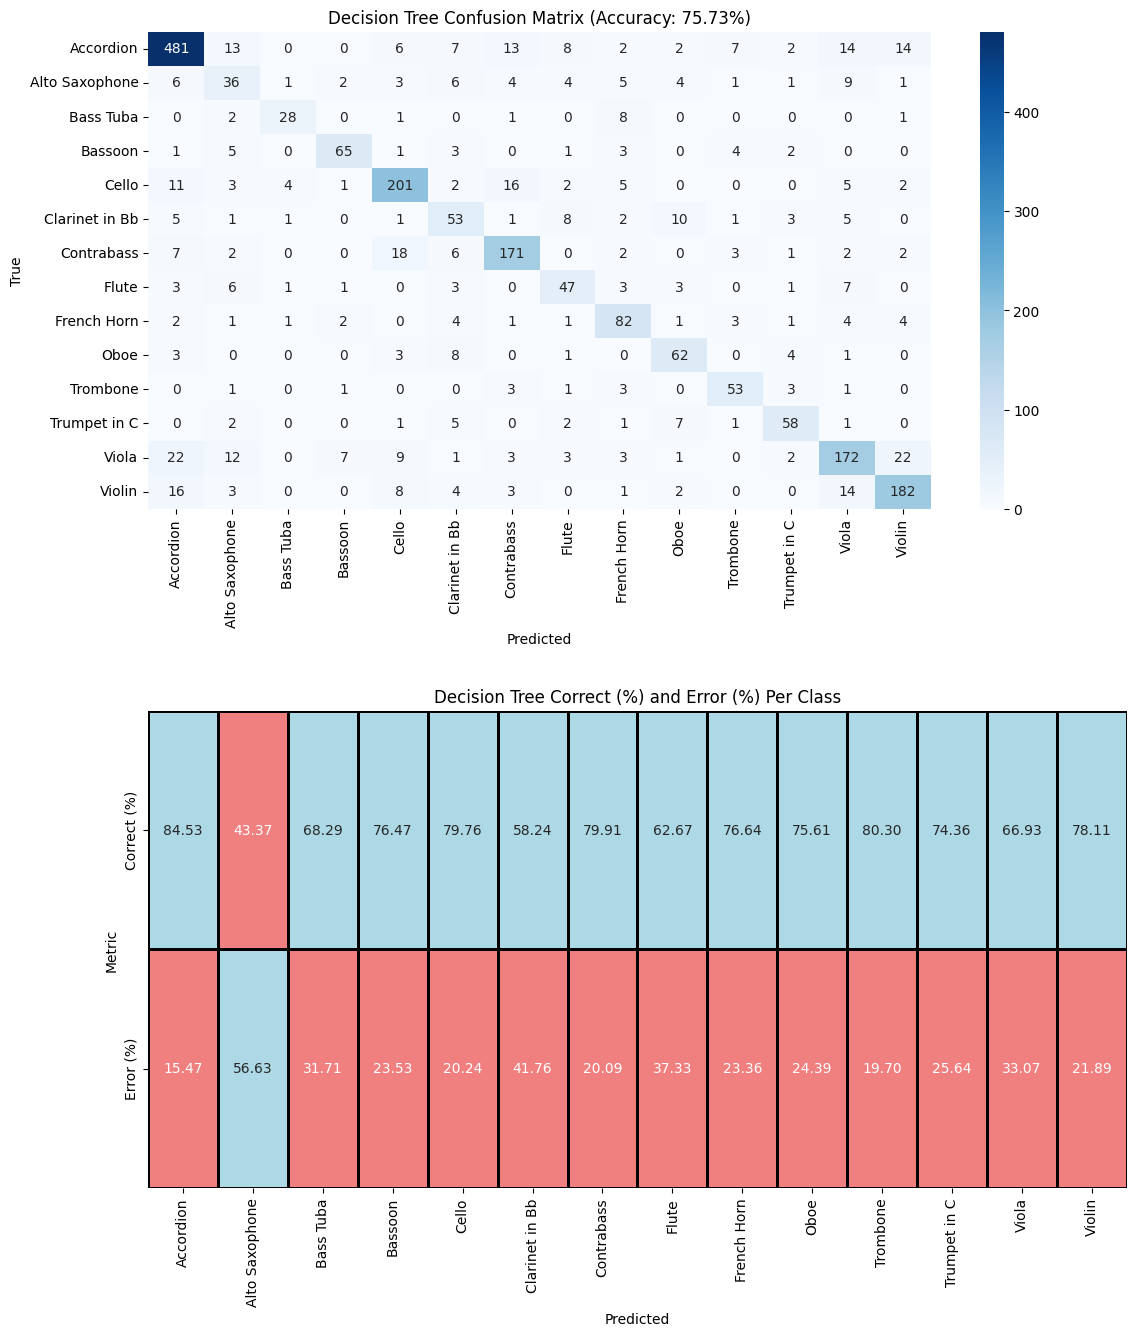

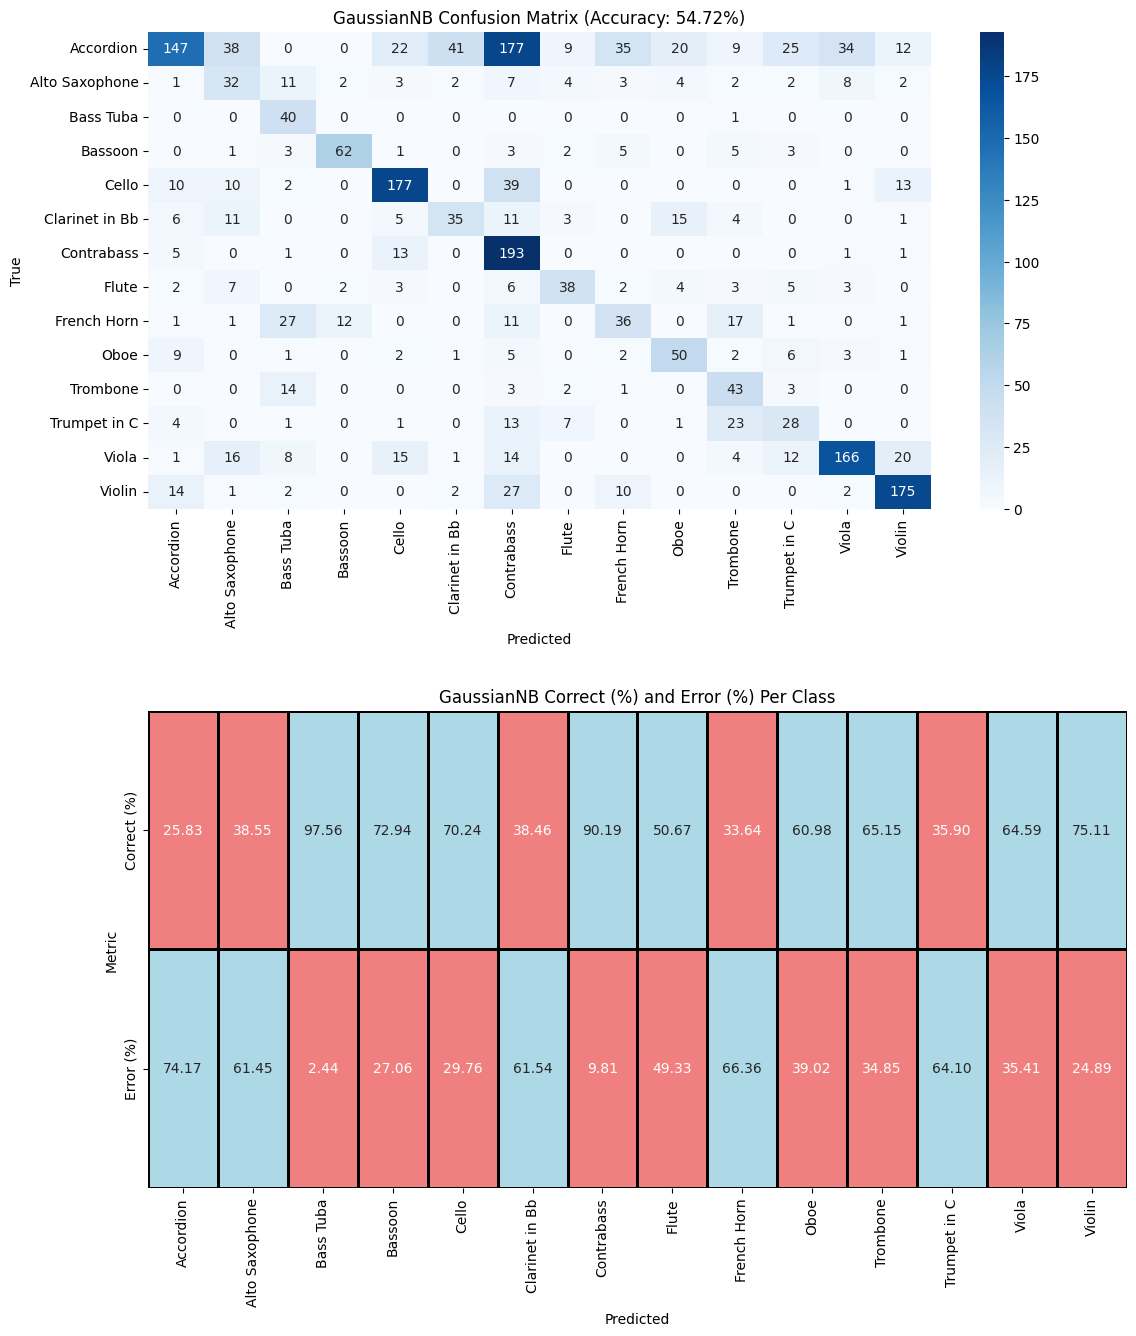

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

for model_name, model in models.items():
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)

     # Get unique label names
    labels = sorted(set(y_val))

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')

    # Calculate the percentage of wrong predictions per class
    total_samples_per_class = np.array([np.sum(y_val == label) for label in labels])
    wrong_samples_per_class = np.array([np.sum(cm[i, :]) - cm[i, i] for i in range(len(labels))])
    percentage_wrong_per_class = np.array([wrong / total * 100 if total > 0 else 0 for total, wrong in zip(total_samples_per_class, wrong_samples_per_class)])

    # Create a DataFrame for the error rate per class
    error_df = pd.DataFrame({'Predicted': labels, 'Error Rate (%)': percentage_wrong_per_class})
    error_df = error_df.sort_values(by='Predicted')

    # Create a custom table to display percentage of correct and error rates
    table_data = pd.DataFrame({
        'Correct (%)': [(100 - error) for error in percentage_wrong_per_class],
        'Error (%)': percentage_wrong_per_class
    }, index=labels).T

    # Visualize the confusion matrix with label names and percentage wrong per class
    plt.figure(figsize=(12, 14))  # Increased figure height for more spacing

    # Plot the custom table above the confusion matrix
    plt.subplot(2, 1, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix (Accuracy: {accuracy * 100:.2f}%)')

    plt.subplot(2, 1, 2)
    ax = sns.heatmap(table_data, annot=True, fmt='.2f', cmap=['lightcoral', 'lightblue'], cbar=False, linewidths=1, linecolor='black')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Metric')
    ax.set_title(f'{model_name} Correct (%) and Error (%) Per Class')

    plt.tight_layout(pad=3)  # Added extra padding between subplots
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a list to store dataframes for each model
results = []

for model_name, model in models.items():
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)

    # Get unique label names
    labels = sorted(set(y_val))

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')

    # Calculate the percentage of wrong predictions per class
    total_samples_per_class = np.array([np.sum(y_val == label) for label in labels])
    wrong_samples_per_class = np.array([np.sum(cm[i, :]) - cm[i, i] for i in range(len(labels))])
    percentage_wrong_per_class = np.array([wrong / total * 100 if total > 0 else 0 for total, wrong in zip(total_samples_per_class, wrong_samples_per_class)])

    # Create a DataFrame for the error rate per class
    error_df = pd.DataFrame({'Predicted': labels, 'Error Rate (%)': percentage_wrong_per_class})
    error_df = error_df.sort_values(by='Predicted')

    # Create a custom table to display percentage of correct and error rates
    table_data = pd.DataFrame({
        'Correct (%)': [(100 - error) for error in percentage_wrong_per_class],
        'Error (%)': percentage_wrong_per_class
    }, index=labels).T

    # Add the model name as an identifier
    table_data['Model'] = model_name

    # Append the results to the list
    results.append(table_data)

# Concatenate all dataframes into a single dataframe
results_df = pd.concat(results)

# Reset index for cleaner presentation
results_df.reset_index(drop=True, inplace=True)

# Display the combined dataframe
results_df

,Accordion,Alto Saxophone,Bass Tuba,Bassoon,Cello,Clarinet in Bb,Contrabass,Flute,French Horn,Oboe,Trombone,Trumpet in C,Viola,Violin,Model
0,95.606327,72.289157,87.804878,81.176471,80.555556,68.131868,67.757009,88.000000,81.308411,76.829268,78.787879,71.794872,85.603113,86.266094,KNN
1,4.393673,27.710843,12.195122,18.823529,19.444444,31.868132,32.242991,12.000000,18.691589,23.170732,21.212121,28.205128,14.396887,13.733906,KNN
2,93.321617,80.722892,97.560976,95.294118,86.904762,80.219780,78.971963,93.333333,87.850467,91.463415,87.878788,83.333333,84.046693,86.266094,SVM
3,6.678383,19.277108,2.439024,4.705882,13.095238,19.780220,21.028037,6.666667,12.149533,8.536585,12.121212,16.666667,15.953307,13.733906,SVM
4,88.400703,74.698795,95.121951,88.235294,84.126984,71.428571,83.177570,89.333333,86.915888,87.804878,84.848485,80.769231,84.824903,87.553648,Logistic Regression
5,11.599297,25.301205,4.878049,11.764706,15.873016,28.571429,16.822430,10.666667,13.084112,12.195122,15.151515,19.230769,15.175097,12.446352,Logistic Regression
6,98.769772,78.313253,97.560976,97.647059,92.857143,82.417582,93.457944,97.333333,91.588785,96.341463,87.878788,97.435897,92.607004,96.566524,Random Forest
7,1.230228,21.686747,2.439024,2.352941,7.142857,17.582418,6.542056,2.666667,8.411215,3.658537,12.121212,2.564103,7.392996,3.433476,Random Forest
8,84.534271,43.373494,68.292683,76.470588,79.761905,58.241758,79.906542,62.666667,76.635514,75.609756,80.303030,74.358974,66.926070,78.111588,Decision Tree
9,15.465729,56.626506,31.707317,23.529412,20.238095,41.758242,20.093458,37.333333,23.364486,24.390244,19.696970,25.641026,33.073930,21.888412,Decision Tree


In [ ]:
# Replace every even index row number starting at index 0 with "Correct %" and every odd index row number with "Error %" in the results_df dataframe
results_df.index = ['Correct %' if i % 2 == 0 else 'Error %' for i in range(results_df.shape[0])]

# Extract the last column
last_column = results_df.iloc[:, -1]

# Remove the last column
results_df = results_df.iloc[:, :-1]

# Insert the last column as the first column
results_df.insert(0, 'Model', last_column)

# Display the modified dataframe
results_df

# Format the percentage columns to display up to 2 decimal places
results_df = results_df.round(3)

results_df

,Model,Accordion,Alto Saxophone,Bass Tuba,Bassoon,Cello,Clarinet in Bb,Contrabass,Flute,French Horn,Oboe,Trombone,Trumpet in C,Viola,Violin
Correct %,KNN,95.61,72.29,87.80,81.18,80.56,68.13,67.76,88.00,81.31,76.83,78.79,71.79,85.60,86.27
Error %,KNN,4.39,27.71,12.20,18.82,19.44,31.87,32.24,12.00,18.69,23.17,21.21,28.21,14.40,13.73
Correct %,SVM,93.32,80.72,97.56,95.29,86.90,80.22,78.97,93.33,87.85,91.46,87.88,83.33,84.05,86.27
Error %,SVM,6.68,19.28,2.44,4.71,13.10,19.78,21.03,6.67,12.15,8.54,12.12,16.67,15.95,13.73
Correct %,Logistic Regression,88.40,74.70,95.12,88.24,84.13,71.43,83.18,89.33,86.92,87.80,84.85,80.77,84.82,87.55
Error %,Logistic Regression,11.60,25.30,4.88,11.76,15.87,28.57,16.82,10.67,13.08,12.20,15.15,19.23,15.18,12.45
Correct %,Random Forest,98.77,78.31,97.56,97.65,92.86,82.42,93.46,97.33,91.59,96.34,87.88,97.44,92.61,96.57
Error %,Random Forest,1.23,21.69,2.44,2.35,7.14,17.58,6.54,2.67,8.41,3.66,12.12,2.56,7.39,3.43
Correct %,Decision Tree,84.53,43.37,68.29,76.47,79.76,58.24,79.91,62.67,76.64,75.61,80.30,74.36,66.93,78.11
Error %,Decision Tree,15.47,56.63,31.71,23.53,20.24,41.76,20.09,37.33,23.36,24.39,19.70,25.64,33.07,21.89


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix

# Initialize lists to store model performance metrics
model_names = []
accuracy_scores = []
precision_scores = []
f1_scores = []
confusion_matrix_scores = []

# Initialize a dictionary to store confusion matrices
confusion_matrices = {}

for model_name, model in models.items():
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)

     # Get unique label names
    labels = sorted(set(y_val))
# Calculate accuracy, precision, and F1 score
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')

    # Compute confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # Store the model's performance metrics
    model_names.append(model_name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    f1_scores.append(f1)
    confusion_matrix_scores.append(cm)

    # Store the confusion matrix in the dictionary
    confusion_matrices[model_name] = cm

# Create a DataFrame to display model performance metrics
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'F1 Score': f1_scores
})

# Sort the DataFrame by accuracy in descending order
metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)

# Display the performance metrics table
print("Model Performance Metrics:")
print(metrics_df)

# Summarize the confusion matrix scores
print("\nConfusion Matrix Summaries:")
for model_name in model_names:
    cm = confusion_matrices[model_name]
    total_samples_per_class = cm.sum(axis=1)
    correct_predictions = np.diag(cm)
    incorrect_predictions = total_samples_per_class - correct_predictions
    class_names = sorted(set(y_val))

    print(f"Model: {model_name}")
    print(f"Class\tCorrect\tIncorrect\tSamples")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}\t{correct_predictions[i]}\t{incorrect_predictions[i]}\t{total_samples_per_class[i]}")
    print()

Model Performance Metrics:
                 Model  Accuracy  Precision  F1 Score
3        Random Forest  0.943126   0.943239  0.942561
1                  SVM  0.877295   0.881132  0.877471
2  Logistic Regression  0.854008   0.855699  0.854447
0                  KNN  0.834751   0.836529  0.832343
4        Decision Tree  0.757277   0.760777  0.758385
5           GaussianNB  0.547246   0.619372  0.538995

Confusion Matrix Summaries:
Model: KNN
Class	Correct	Incorrect	Samples
Accordion	544	25	569
Alto Saxophone	60	23	83
Bass Tuba	36	5	41
Bassoon	69	16	85
Cello	203	49	252
Clarinet in Bb	62	29	91
Contrabass	145	69	214
Flute	66	9	75
French Horn	87	20	107
Oboe	63	19	82
Trombone	52	14	66
Trumpet in C	56	22	78
Viola	220	37	257
Violin	201	32	233

Model: SVM
Class	Correct	Incorrect	Samples
Accordion	531	38	569
Alto Saxophone	67	16	83
Bass Tuba	40	1	41
Bassoon	81	4	85
Cello	219	33	252
Clarinet in Bb	73	18	91
Contrabass	169	45	214
Flute	70	5	75
French Horn	94	13	107
Oboe	75	7	82
Trombone	58	8	66
Tru

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
from tabulate import tabulate


# Initialize lists to store model performance metrics
model_names = []
accuracy_scores = []
precision_scores = []
f1_scores = []

# Initialize a dictionary to store confusion matrices
confusion_matrices = {}

for model_name, model in models.items():
    # Predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Calculate accuracy, precision, and F1 score
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')

    # Compute confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # Store the model's performance metrics
    model_names.append(model_name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    f1_scores.append(f1)

    # Store the confusion matrix in the dictionary
    confusion_matrices[model_name] = cm

# Create a DataFrame to display model performance metrics
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'F1 Score': f1_scores
})

# Sort the DataFrame by accuracy in descending order
metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)

# Display the performance metrics table
print("Model Performance Metrics:")
print(tabulate(metrics_df, headers='keys', tablefmt='pretty'))

# Summarize the confusion matrix scores
print("\nConfusion Matrix Summaries:")
for model_name in model_names:
    cm = confusion_matrices[model_name]
    total_samples_per_class = cm.sum(axis=1)
    correct_predictions = np.diag(cm)
    incorrect_predictions = total_samples_per_class - correct_predictions
    class_names = sorted(set(y_val))

    print(f"Model: {model_name}")
    headers = ["Class", "Correct", "Incorrect", "Samples"]
    data = [[class_name, correct, incorrect, total] for class_name, correct, incorrect, total in zip(class_names, correct_predictions, incorrect_predictions, total_samples_per_class)]
    print(tabulate(data, headers, tablefmt='pretty'))
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Performance Metrics:
+---+---------------------+--------------------+--------------------+--------------------+
|   |        Model        |      Accuracy      |     Precision      |      F1 Score      |
+---+---------------------+--------------------+--------------------+--------------------+
| 3 |    Random Forest    | 0.9373040752351097 | 0.9373874970025644 | 0.9366009717272551 |
| 1 |         SVM         | 0.877295118674429  | 0.8811316441387013 | 0.877471448197624  |
| 2 | Logistic Regression | 0.8540080609046127 | 0.8556990305969971 | 0.8544471138317874 |
| 0 |         KNN         | 0.8347514554411106 | 0.836528923784259  | 0.8323432501884787 |
| 4 |    Decision Tree    | 0.7622033139274519 | 0.7649473058703812 | 0.7630502319697007 |
| 5 |     GaussianNB      | 0.5472458575906852 | 0.6193715368354756 | 0.5389950476715758 |
+---+---------------------+--------------------+--------------------+--------------------+

Confusion Matrix Summaries:
Model: KNN
+----------------+-----

Fine-tuning SVMs typically involves the selection of the kernel and the evaluation of the C and gamma parameters. The C parameter balances the correct classification of training examples with the maximization of the decision function's margin, while the gamma parameter determines how far the influence of a single training example extends. In practice, Python's GridSearchCV library is commonly used for fine-tuning SVM hyperparameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# Coarse Search
param_dist_coarse = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

svm_model_coarse = SVC()
randomized_search_coarse = RandomizedSearchCV(
    svm_model_coarse, param_distributions=param_dist_coarse, n_iter=10,
    cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)
randomized_search_coarse.fit(X_train, y_train)

best_params_coarse = randomized_search_coarse.best_params_
print("Best Parameters (Coarse Search):", best_params_coarse)

# Finer Search
param_grid_fine = {
    'C': [best_params_coarse['C'] / 10, best_params_coarse['C'], best_params_coarse['C'] * 10],
    'gamma': [best_params_coarse['gamma'] / 10, best_params_coarse['gamma'], best_params_coarse['gamma'] * 10],
    'kernel': [best_params_coarse['kernel']]
}

svm_model_fine = SVC()
grid_search_fine = GridSearchCV(
    svm_model_fine, param_grid=param_grid_fine,
    cv=5, scoring='accuracy', n_jobs=-1
)
grid_search_fine.fit(X_train, y_train)

best_params_fine = grid_search_fine.best_params_
print("Best Parameters (Fine Search):", best_params_fine)

# Use the best model for predictions on the validation set
best_svm_model = grid_search_fine.best_estimator_
y_pred = best_svm_model.predict(X_val)

# Evaluate the performance of the best model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy with Best Model:", accuracy)


NameError: ignored

For the KNN model, we will implement a loop function that iterates through k values from 1 to 20 to determine the optimal k value for the model (or a larger k, depending on the observed results).

Optimal k value: 1 with Accuracy: 0.8620689655172413

Model Performance Metrics:
    k Value  Accuracy  Precision    Recall  F1 Score
0         1  0.862069   0.862277  0.862069  0.861366
1         2  0.852665   0.856052  0.852665  0.851068
2         3  0.842812   0.843917  0.842812  0.841097
3         4  0.836991   0.838923  0.836991  0.834646
4         5  0.834751   0.836529  0.834751  0.832343
5         6  0.829825   0.833911  0.829825  0.827125
6         7  0.825347   0.829007  0.825347  0.823062
7         8  0.821317   0.825017  0.821317  0.818820
8         9  0.816838   0.821452  0.816838  0.814298
9        10  0.813704   0.819813  0.813704  0.811315
10       11  0.810121   0.816940  0.810121  0.807687
11       12  0.803851   0.812121  0.803851  0.801571
12       13  0.801612   0.808986  0.801612  0.799168
13       14  0.798030   0.808336  0.798030  0.795537
14       15  0.791312   0.800975  0.791312  0.788794
15       16  0.788625   0.798560  0.788625  0.785399
16       17  0.783

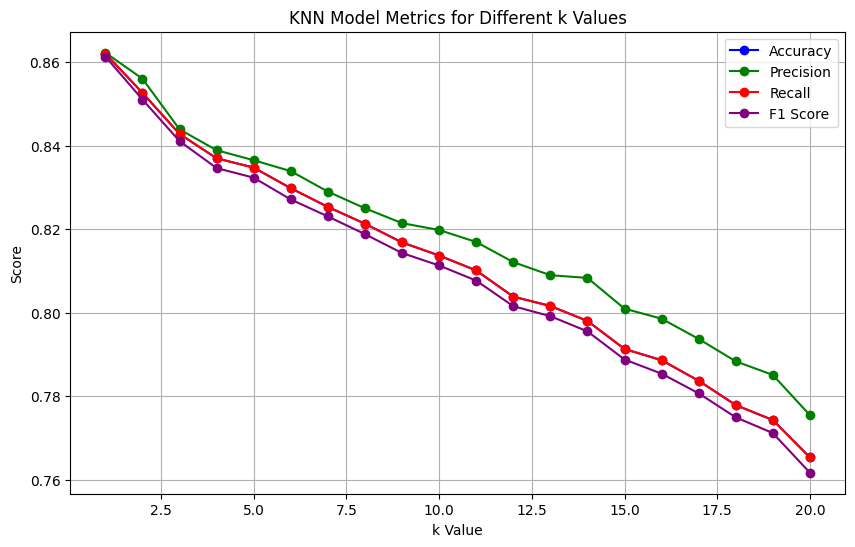

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# Initialize lists to store model performance metrics
k_values = list(range(1, 21))  # Adjust the range based on your preferences
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate through different values of k
for k in k_values:
    # Create KNN model with the current k value
    knn_model = KNeighborsClassifier(n_neighbors=k)

    # Fit the model on the training data
    knn_model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = knn_model.predict(X_val)

    # Evaluate the model's performance and store the metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Find the optimal k value that gives the highest accuracy
optimal_k = k_values[accuracy_scores.index(max(accuracy_scores))]
max_accuracy = max(accuracy_scores)

print(f"Optimal k value: {optimal_k} with Accuracy: {max_accuracy}")

# Display the metrics in a tabular format
metrics_df = pd.DataFrame({
    'k Value': k_values,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

# Sort the DataFrame by accuracy in descending order
metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)

# Display the metrics table
print("\nModel Performance Metrics:")
print(metrics_df)

# Plot the accuracy scores for different k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b', label='Accuracy')
plt.plot(k_values, precision_scores, marker='o', linestyle='-', color='g', label='Precision')
plt.plot(k_values, recall_scores, marker='o', linestyle='-', color='r', label='Recall')
plt.plot(k_values, f1_scores, marker='o', linestyle='-', color='purple', label='F1 Score')

plt.title('KNN Model Metrics for Different k Values')
plt.xlabel('k Value')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In the case of Logistic Regression, we will explore larger penalty parameters and different regularizations to address overfitting issues.

In [ ]:
# Attempt #1
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Different regularization types
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Larger penalty parameters
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]  # Only applicable for 'elasticnet' penalty
}

# Choose the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed

# Create GridSearchCV instance
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV instance to your data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best Logistic Regression model
best_logreg_model = grid_search.best_estimator_

# Use the best model for predictions on the validation set
y_pred = best_logreg_model.predict(X_val)

# Evaluate the performance of the best model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy with Best Model:", accuracy)


In [ ]:
# Attempt #2

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

# Define the parameter distributions for randomized search
param_dist = {
    'penalty': ['l1', 'l2'],
    'C': uniform(loc=0.001, scale=100)  # Using a continuous distribution for 'C'
}

# Choose the Logistic Regression model
logreg_model = LogisticRegression(solver='liblinear')

# Create RandomizedSearchCV instance
randomized_search = RandomizedSearchCV(
    logreg_model, param_distributions=param_dist, n_iter=10,
    cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)

# Fit the RandomizedSearchCV instance to your data
randomized_search.fit(X_train, y_train)

# Get the best parameters from the randomized search
best_params = randomized_search.best_params_
print("Best Parameters:", best_params)

# Get the best Logistic Regression model
best_logreg_model = randomized_search.best_estimator_

# Use the best model for predictions on the validation set
y_pred = best_logreg_model.predict(X_val)

# Evaluate the performance of the best model
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Store the metrics in a DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
})

# Print the tabular format
print("Validation Metrics with Best Model:")
print(metrics_df)

# Plot the metrics
plt.figure(figsize=(8, 5))
sns.barplot(x='Metric', y='Score', data=metrics_df, palette='viridis')
plt.title('Validation Metrics with Best Logistic Regression Model')
plt.show()


Feature Scaling: Standardize or normalize numerical features to bring them to a similar scale.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

Feature Selection: Select relevant features and remove irrelevant ones.
Use techniques like recursive feature elimination (RFE) or feature importance from tree-based models.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Recursive Feature Elimination (RFE) with Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rfe = RFE(estimator=rf_model, n_features_to_select=10)
X_train_selected = rfe.fit_transform(X_train, y_train)
X_val_selected = rfe.transform(X_val)


Dimensionality Reduction: Apply dimensionality reduction techniques if your dataset has a large number of features. Use techniques like PCA (Principal Component Analysis).

In [ ]:
from sklearn.decomposition import PCA

# Dimensionality reduction with PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
